In [1]:
!pip install bayesian-optimization --quiet

In [2]:
!pip install snntorch --quiet

In [3]:
from google.colab \
import drive
import os, glob

my_name = 'population_learning_decoding.ipynb'
cut = len(my_name)

drive.mount(os.getcwd() + '/drive')
my_path = glob.glob(os.getcwd() + '/**/' +
my_name, recursive = True)

path = my_path[0][:-cut]
print(path)
# print(type(my_path[0]))

os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PhD/FLAP_MURI_1119_workshop/


In [4]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchaudio

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import itertools
import random
import statistics
import tqdm

from sklearn.svm import SVR
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import os
from bayes_opt import BayesianOptimization

import keras
keras_v1=int(keras.__version__[0])<=1
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, Dropout


In [5]:
# functions for running and training a spiking neural network

class ConDivNet2dStimSparse_countTimeReadout(torch.nn.Module):
    """spiking neural network in snntorch."""

    def __init__(self, timesteps, Nin, Nh, Nout, pcon, alpha):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        self.inp_1 = int(Nin/4)
        self.inp_2 = int(Nin/4)
        self.inp_3 = int(Nin/4)
        self.inp_4 = int(Nin/4)
        self.h = Nh # number of hidden neurons
        self.out = Nout
        self.p = pcon # connection sparsity (% of connections to set to zero)
        self.alpha = alpha
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.inp_1_offsets = 0.1*torch.randn(self.inp_1)
        self.inp_2_offsets = 0.1*torch.randn(self.inp_2)
        self.inp_3_offsets = 0.1*torch.randn(self.inp_3)
        self.inp_4_offsets = 0.1*torch.randn(self.inp_4)

        self.time_readout_vec = torch.nn.Parameter(0.1*torch.randn(Nout,2))
        self.count_readout_vec = torch.nn.Parameter(0.1*torch.randn(Nout,2))

        # global parameters
        alpha_min = 0.7
        alpha_max = 0.9
        thr_min = 0.0
        thr_max = 0.5

##################################################################################################

        # stimulus to quadrant 1 input layer
        self.fc_in_1 = torch.nn.Linear(in_features=self.inp_1, out_features=self.inp_1, bias=False)
        # randomly initialize parameters for input layer
        alpha_in_1 = (alpha_max-alpha_min)*torch.rand(self.inp_1) + alpha_min
        beta_in_1 = alpha_in_1 - 0.1
        thr_in_1 = torch.rand(self.inp_1)*(thr_max-thr_min) + thr_min
        self.lif_in_1 = snn.Alpha(alpha=alpha_in_1, beta=beta_in_1,
                                threshold=thr_in_1,
                                learn_threshold=False, spike_grad=spike_grad)

        # stimulus to quadrant 2 input layer
        self.fc_in_2 = torch.nn.Linear(in_features=self.inp_2, out_features=self.inp_2, bias=False)
        # randomly initialize parameters for input layer
        alpha_in_2 = (alpha_max-alpha_min)*torch.rand(self.inp_2) + alpha_min
        beta_in_2 = alpha_in_2 - 0.1
        thr_in_2 = torch.rand(self.inp_2)*(thr_max-thr_min) + thr_min
        self.lif_in_2 = snn.Alpha(alpha=alpha_in_2, beta=beta_in_2,
                                threshold=thr_in_2,
                                learn_threshold=False, spike_grad=spike_grad)

        # stimulus to quadrant 3 input layer
        self.fc_in_3 = torch.nn.Linear(in_features=self.inp_3, out_features=self.inp_3, bias=False)
        # randomly initialize parameters for input layer
        alpha_in_3 = (alpha_max-alpha_min)*torch.rand(self.inp_3) + alpha_min
        beta_in_3 = alpha_in_3 - 0.1
        thr_in_3 = torch.rand(self.inp_3)*(thr_max-thr_min) + thr_min
        self.lif_in_3 = snn.Alpha(alpha=alpha_in_3, beta=beta_in_3,
                                threshold=thr_in_3,
                                learn_threshold=False, spike_grad=spike_grad)

        # stimulus to quadrant 4 input layer
        self.fc_in_4 = torch.nn.Linear(in_features=self.inp_4, out_features=self.inp_4, bias=False)
        # randomly initialize parameters for input layer
        alpha_in_4 = (alpha_max-alpha_min)*torch.rand(self.inp_4) + alpha_min
        beta_in_4 = alpha_in_4 - 0.1
        thr_in_4 = torch.rand(self.inp_4)*(thr_max-thr_min) + thr_min
        self.lif_in_4 = snn.Alpha(alpha=alpha_in_4, beta=beta_in_4,
                                threshold=thr_in_4,
                                learn_threshold=False, spike_grad=spike_grad)


        # quadrant 1 input layer to E1 layer
        self.fc_h_1 = torch.nn.Linear(in_features=self.inp_1, out_features=self.h, bias=False)
        torch.nn.init.sparse_(self.fc_h_1.weight, sparsity=self.p, std=1./np.sqrt(self.inp_1*(1-self.p)))
        # quadrant 2 input layer to E1 layer
        self.fc_h_2 = torch.nn.Linear(in_features=self.inp_2, out_features=self.h, bias=False)
        torch.nn.init.sparse_(self.fc_h_2.weight, sparsity=self.p, std=1./np.sqrt(self.inp_2*(1-self.p)))
        # quadrant 1 input layer to E1 layer
        self.fc_h_3 = torch.nn.Linear(in_features=self.inp_3, out_features=self.h, bias=False)
        torch.nn.init.sparse_(self.fc_h_3.weight, sparsity=self.p, std=1./np.sqrt(self.inp_3*(1-self.p)))
        # quadrant 2 input layer to E1 layer
        self.fc_h_4 = torch.nn.Linear(in_features=self.inp_4, out_features=self.h, bias=False)
        torch.nn.init.sparse_(self.fc_h_4.weight, sparsity=self.p, std=1./np.sqrt(self.inp_4*(1-self.p)))
        # randomly initialize parameters for E1 layer
        alpha_h = (alpha_max-alpha_min)*torch.rand(self.h) + alpha_min
        beta_h = alpha_h - 0.1
        thr_h = torch.rand(self.h)*(thr_max-thr_min) + thr_min
        self.lif_h = snn.Alpha(alpha=alpha_h, beta=beta_h, threshold=thr_h,
                                learn_threshold=False, spike_grad=spike_grad)

##################################################################################################

        # hidden layer to output layer
        self.fc_out = torch.nn.Linear(in_features=self.h, out_features=self.out,bias=False)
        torch.nn.init.sparse_(self.fc_out.weight, sparsity=self.p, std=1./np.sqrt(self.h*(1-self.p)))
        # randomly initialize parameters for B layer
        alpha_out = (alpha_max-alpha_min)*torch.rand(self.out) + alpha_min
        beta_out = alpha_out - 0.1
        thr_out = torch.rand(self.out)*(thr_max-thr_min) + thr_min
        self.lif_out = snn.Alpha(alpha=alpha_out, beta=beta_out, threshold=thr_out,
                                learn_threshold=False, spike_grad=spike_grad)

        # # output layer to readout neuron
        self.fc_readout = torch.nn.Linear(in_features=self.out, out_features=2,bias=False)
        # # randomly initialize decay rate for single output neuron
        thr_readout = torch.ones(2)
        beta_readout = torch.rand(2)
        # # leaky integrator readout neuron used for reconstruction
        self.li_readout = snn.Leaky(beta=beta_readout, threshold=thr_readout, learn_beta=True,
                                    spike_grad=spike_grad, reset_mechanism="none")


    def forward(self, stim):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        pre_in_1, post_in_1, mem_in_1 = self.lif_in_1.init_alpha()
        pre_in_2, post_in_2, mem_in_2 = self.lif_in_2.init_alpha()
        pre_in_3, post_in_3, mem_in_3 = self.lif_in_3.init_alpha()
        pre_in_4, post_in_4, mem_in_4 = self.lif_in_4.init_alpha()
        presyn_h, postsyn_h, mem_h = self.lif_h.init_alpha()
        presyn_out, postsyn_out, mem_out = self.lif_out.init_alpha()
        mem_readout = self.li_readout.init_leaky()

        # Empty lists to record outputs
        spk_in_1_rec = []
        spk_in_2_rec = []
        spk_in_3_rec = []
        spk_in_4_rec = []
        spk_h_rec = []
        spk_out_rec = []
        mem_readout_rec = []

        deltatt = 10
        kernelRange = torch.linspace(0,1,deltatt+1)
        sigma = 0.1
        half = kernelRange[int(deltatt/2)]
        k = torch.exp(-((kernelRange-half)**2)/sigma)
        time_kernel = torch.zeros((self.out,deltatt+1))
        for i in range(self.out):
            time_kernel[i,:] = k

        deltatc = 70
        kernelRange = torch.linspace(0,1,deltatc+1)
        sigma = 0.1
        half = kernelRange[int(deltatc/2)]
        k = torch.exp(-((kernelRange-half)**2)/sigma)
        count_kernel = torch.zeros((self.out,deltatc+1))
        for i in range(self.out):
            count_kernel[i,:] = k

        # loop over time
        for step in range(self.timesteps):
            x = stim[step, 0, :]*torch.ones(self.inp_1)
            y = stim[step, 1, :]*torch.ones(self.inp_1)

            stim_1 = torch.sqrt(x[0]**2 + y[0]**2)*(x > self.inp_1_offsets)*(y > self.inp_1_offsets) # first quadrant
            cur_in_1 = self.fc_in_1(stim_1)
            spk_in_1, pre_in_1, post_in_1, mem_in_1 = self.lif_in_1(cur_in_1,pre_in_1,post_in_1,mem_in_1)

            stim_2 = torch.sqrt(x[0]**2 + y[0]**2)*(x < self.inp_2_offsets)*(y > self.inp_2_offsets) # second quadrant
            cur_in_2 = self.fc_in_2(stim_2)
            spk_in_2, pre_in_2, post_in_2, mem_in_2 = self.lif_in_2(cur_in_2,pre_in_2,post_in_2,mem_in_2)

            stim_3 = torch.sqrt(x[0]**2 + y[0]**2)*(x < self.inp_3_offsets)*(y < self.inp_3_offsets) # third quadrant
            cur_in_3 = self.fc_in_3(stim_3)
            spk_in_3, pre_in_3, post_in_3, mem_in_3 = self.lif_in_3(cur_in_3,pre_in_3,post_in_3,mem_in_3)

            stim_4 = torch.sqrt(x[0]**2 + y[0]**2)*(x > self.inp_4_offsets)*(y < self.inp_4_offsets) # fourth quadrant
            cur_in_4 = self.fc_in_4(stim_4)
            spk_in_4, pre_in_4, post_in_4, mem_in_4 = self.lif_in_4(cur_in_4,pre_in_4,post_in_4,mem_in_4)

            cur_h_1 = self.fc_h_1(spk_in_1)
            cur_h_2 = self.fc_h_2(spk_in_2)
            cur_h_3 = self.fc_h_3(spk_in_3)
            cur_h_4 = self.fc_h_4(spk_in_4)

            cur_h = cur_h_1 + cur_h_2 + cur_h_3 + cur_h_4
            spk_h, presyn_h, postsyn_h, mem_h = self.lif_h(cur_h, presyn_h, postsyn_h, mem_h)

            cur_out = self.fc_out(spk_h)
            spk_out, presyn_out, postsyn_out, mem_out = self.lif_out(cur_out, presyn_out, postsyn_out, mem_out)

            cur_readout = self.fc_readout(spk_out)
            _, mem_readout = self.li_readout(cur_readout, mem_readout)

            spk_in_1_rec.append(spk_in_1)
            spk_in_2_rec.append(spk_in_2)
            spk_in_3_rec.append(spk_in_3)
            spk_in_4_rec.append(spk_in_4)
            spk_h_rec.append(spk_h)
            spk_out_rec.append(spk_out)
            mem_readout_rec.append(mem_readout)


        mem_readout_rec = torch.stack(mem_readout_rec)
        mem_new = mem_readout_rec.view(self.timesteps, 2, 1)
        spk_in_1_rec = torch.stack(spk_in_1_rec)
        spk_in_2_rec = torch.stack(spk_in_2_rec)
        spk_in_3_rec = torch.stack(spk_in_3_rec)
        spk_in_4_rec = torch.stack(spk_in_4_rec)
        spk_h_rec = torch.stack(spk_h_rec)
        spk_out_rec = torch.stack(spk_out_rec)

        timevec = torchaudio.functional.convolve(torch.t(spk_out_rec),time_kernel,mode='valid')
        countvec = torchaudio.functional.convolve(torch.t(spk_out_rec),count_kernel,mode='valid')
        yhat_time_pre = torch.matmul(torch.t(timevec),self.time_readout_vec)
        yhat_count = torch.matmul(torch.t(countvec),self.count_readout_vec)
        tmax = yhat_count.shape[0]
        yhat_time = yhat_time_pre[:tmax,:]
        readout_rec = self.alpha*yhat_time + (1-self.alpha)*yhat_count
        readout = readout_rec.view(tmax, 2, 1)

        return [readout, mem_new, spk_in_1_rec, spk_in_2_rec, spk_in_3_rec, spk_in_4_rec, spk_h_rec, spk_out_rec]
        # return [readout, spk_in_1_rec, spk_in_2_rec, spk_in_3_rec, spk_in_4_rec, spk_h_rec, spk_out_rec]


class RegressionDataset_wFreqs(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples # number of generated samples
        feature_lst = [] # store each generated sample in a list

        f1 = 2.5
        f2 = 5.
        f3 = 10.
        amp = 0.4

        # generate linear functions one by one
        for idx in range(num_samples):
            end = float(1)
            lin_vec = torch.linspace(start=0.0, end=end, steps=timesteps) # generate linear function from 0 to end
            feature = lin_vec.view(timesteps, 1)
            # feature = lin_vec.view(timesteps)
            feature_lst.append(feature) # add sample to list

        self.features = torch.stack(feature_lst, dim=1) # convert list to tensor

        # option to generate linear function or square-root function
        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)

        elif mode == 'sine':
#             print(self.features)
            self.labels = 0.9*torch.sin(2.*torch.pi*5.*self.features)

        elif mode == '2dsine':
            s = 0.3*torch.sin(2.*torch.pi*5.*self.features)
            c = 0.9*torch.cos(2.*torch.pi*5.*self.features)
            self.labels = torch.hstack((c,s))

        elif mode == '2dsineDis':
            ells = 0.3*torch.sin(2.*torch.pi*5.*self.features)
            ellc = 0.9*torch.cos(2.*torch.pi*5.*self.features)
            s = ells*(self.features < 0.25) + ellc*(self.features > 0.25)*(self.features < 0.85) + ells*(self.features > 0.85)
            c = ellc*(self.features < 0.25) + ells*(self.features > 0.25)*(self.features < 0.85) + ellc*(self.features > 0.85)
            self.labels = torch.hstack((c,s))

        elif mode == '2dsos':
            a1 = 0.4
            a2 = 0.4
            f1 = 4.
            f2 = 20.
            c1 = a1*torch.cos(2.*torch.pi*f1*self.features)
            c2 = a2*torch.cos(2.*torch.pi*f2*self.features)
            c = c1 + c2
            s1 = a1*torch.sin(2.*torch.pi*f1*self.features)
            s2 = a2*torch.sin(2.*torch.pi*f2*self.features)
            s = s1 + s2
            self.labels1 = torch.hstack((c1,s1))
            self.labels2 = torch.hstack((c2,s2))
            self.labels = torch.hstack((c,s))


        elif mode == 'sos':
            self.labels = amp*torch.sin(2.*torch.pi*f1*self.features) + amp*torch.sin(2.*torch.pi*f2*self.features)

        else:
            raise NotImplementedError("'linear', 'sqrt', 'sine'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""

        return self.features[:, idx, :], self.labels[:, :2, 0], self.labels1[:, :2, 0], self.labels2[:, :2, 0]

def makeRaster2D(s, spk1, spk2, spk3, spk4, spkh, spkout, mem, Nh, seednum, tag):
    if not os.path.exists('rasters'):
        os.mkdir('rasters')
    if not os.path.exists(f'rasters/Nh{Nh}'):
        os.mkdir(f'rasters/Nh{Nh}')
    fname = f'rasters/Nh{Nh}/seed{seednum}_{tag}.png'

    xpos = s[:,0, 0].detach().numpy()
    ypos = s[:,1, 0].detach().numpy()
    memx = mem[:,0,0].detach().numpy()
    memy = mem[:,1,0].detach().numpy()
    spk_1_plot = spk1.detach().numpy().T
    spk_2_plot = spk2.detach().numpy().T
    spk_3_plot = spk3.detach().numpy().T
    spk_4_plot = spk4.detach().numpy().T
    spk_in_plot = np.vstack((spk_1_plot,spk_2_plot,spk_3_plot,spk_4_plot))
    spk_h_plot = spkh.detach().numpy().T
    spk_out_plot = spkout.detach().numpy().T
    # mem_plot = mem.detach().numpy()[:,0]
    Nin = spk_in_plot.shape[0]
    Nout = spk_out_plot.shape[0]
    num_steps = len(xpos)

    fig, ax = plt.subplots(5,figsize=(5,7),gridspec_kw={'height_ratios': [1, 3, 3, 3, 1]})
    for axi in range(len(ax)):
        ax[axi].set_xlim([0,num_steps])
        if axi != len(ax) - 1:
            ax[axi].set_xticks([])
    ax[0].plot(xpos,color='blue',label='x')
    ax[0].plot(ypos,color='red',label='y')
    ax[0].set_ylabel('stim')
    ax[0].legend(ncol=2,bbox_to_anchor=(0.3,1))
    ax[1].set_ylim([-1,Nin])
    ax[1].set_yticks([0,Nin])
    ax[1].imshow(spk_in_plot, cmap="binary",aspect="auto")
    ax[1].set_ylabel('input')
    ax[2].set_ylim([-1,Nh])
    ax[2].set_yticks([0,Nh])
    ax[2].imshow(spk_h_plot, cmap="binary",aspect="auto")
    ax[2].set_ylabel('hidden')
    ax[3].set_ylim([-1,Nout])
    ax[3].set_yticks([0,Nout])
    ax[3].imshow(spk_out_plot, cmap="binary",aspect="auto")
    ax[3].set_ylabel('output')
    ax[3].set_xticks([])
    ax[4].plot(memx,color='blue')
    ax[4].plot(memy,color='red')
    ax[4].set_ylabel('readout')
    ax[4].set_xlabel('time',fontsize=20)
    # plt.savefig(fname,bbox_inches='tight',dpi=200)
    plt.show()
    plt.close()


In [6]:
# LSTM = Long Short Term Memory
class LSTMRegression(object):

    """
    Class for the gated recurrent unit (GRU) decoder

    Parameters
    ----------
    units: integer, optional, default 400
        Number of hidden units in each layer

    dropout: decimal, optional, default 0
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=400,dropout=0,num_epochs=10,verbose=0):
         self.units=units
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose


    def fit(self,X_train,y_train):

        """
        Train LSTM Decoder

        Parameters
        ----------
        X_train: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        model=Sequential() #Declare model
        #Add recurrent layer
        if keras_v1:
            model.add(LSTM(self.units,dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
        else:
            model.add(LSTM(self.units,dropout=self.dropout,recurrent_dropout=self.dropout)) #Within recurrent layer, include dropout
        if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)

        #Add dense connections to output layer
        model.add(Dense(y_train.shape[1]))

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy']) #Set loss function and optimizer
        if keras_v1:
            model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
        else:
            model.fit(X_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_test):

        """
        Predict outcomes using trained LSTM Decoder

        Parameters
        ----------
        X_test: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted = self.model.predict(X_test) #Make predictions
        return y_test_predicted


# GRU = Gated Recurrent Unit
class GRURegression(object):

    """
    Class for the gated recurrent unit (GRU) decoder

    Parameters
    ----------
    units: integer, optional, default 400
        Number of hidden units in each layer

    dropout: decimal, optional, default 0
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=400,dropout=0,num_epochs=10,verbose=0):
         self.units=units
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose


    def fit(self,X_train,y_train):

        """
        Train GRU Decoder

        Parameters
        ----------
        X_train: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        model=Sequential() #Declare model
        #Add recurrent layer
        if keras_v1:
            model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
        else:
            model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout=self.dropout,recurrent_dropout=self.dropout))
        if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)

        #Add dense connections to output layer
        model.add(Dense(y_train.shape[1]))

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy']) #Set loss function and optimizer
        if keras_v1:
            model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
        else:
            model.fit(X_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_test):

        """
        Predict outcomes using trained GRU Decoder

        Parameters
        ----------
        X_test: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted = self.model.predict(X_test) #Make predictions
        return y_test_predicted

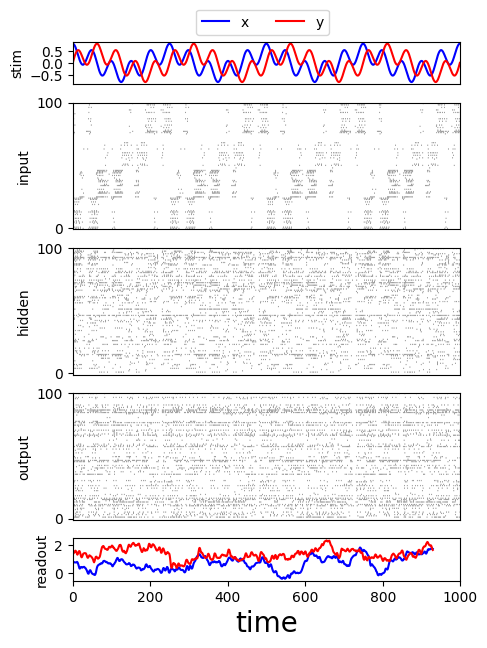

In [33]:
# number of neurons in each of the three layers
Nin = 100
Nh = 100
Nout = 100

seednum=1
alpha = 0.5
num_steps = 1000
tf = num_steps
dt = 1
tvec = np.arange(0,tf,dt)
flag = torch.cuda.is_available()
device = torch.device("cuda") if flag else torch.device("cpu")
if flag:
    print('device set to cuda')
    torch.set_default_device('cuda')
tf = num_steps
######################################################################
num_samples = 1
mode = "2dsos" # type of stimulus
batch_size = 1 # only one sample to learn
######################################################################

Ns = [Nin, Nh, Nout]
tag = 'post'

pconvec = [0.3]

for pcon in pconvec:

    dataset = RegressionDataset_wFreqs(timesteps=num_steps,num_samples=num_samples, mode=mode)

    torch.manual_seed(seednum)
    random.seed(seednum)
    np.random.seed(seednum)

    model = ConDivNet2dStimSparse_countTimeReadout(timesteps=num_steps, Nin=Nin, Nh=Nh, Nout=Nout, pcon=pcon, alpha=alpha).to(device)

    with torch.no_grad():
        feature = dataset.features
        label = dataset.labels
        label1 = dataset.labels1
        label2 = dataset.labels2
        feature = feature.to(device)
        s = label.to(device)
        readout, mem, spk1, spk2, spk3, spk4, spkh, spkout = model(s)
    tmax = readout.shape[0]
    makeRaster2D(s.cpu(), spk1.cpu(), spk2.cpu(), spk3.cpu(), spk4.cpu(), spkh.cpu(), spkout.cpu(), readout.cpu(), Nh, seednum, tag)

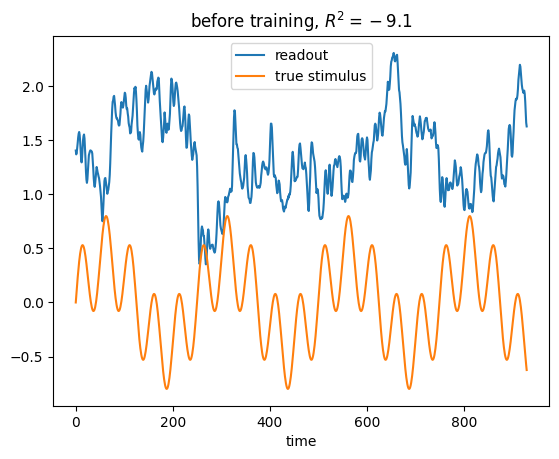

In [34]:
r2 = r2_score(s.detach().numpy()[:tmax,:,0], readout.detach().numpy()[:,:,0])
plt.title(f'before training, $R^2={r2:.3}$')
plt.plot(readout.detach().numpy()[:,1,0],label='readout')
plt.plot(s.detach().numpy()[:tmax,1,0],label='true stimulus')
plt.xlabel('time')
plt.legend()
plt.show()

In [35]:
# bin spikes
spk = spkout.cpu().detach().numpy() # decode the output spikes (change to 'spkh' to decode the hidden layer spikes)
deltat = 25
tf=spk.shape[0]
n_neurons=spk.shape[1]
T=50
n_time_bins=int(T/deltat)
n_samples=tf-T+1
y=label[:n_samples,:,0].cpu()

# y4=y4full[:n_samples]
# y20=y20full[:n_samples]
X=np.zeros((n_samples,n_time_bins,n_neurons))
for n in range(n_samples):
    sub=spk[n:n+T,:]
    s=[np.sum(sub[x:x+deltat,:],axis=0) for x in range(0,T,deltat)]
    X[n,:,:]=s

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.5,shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_validate, y_validate, test_size=0.5,shuffle=False)
X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.5,shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_validate, y_validate, test_size=0.5,shuffle=False)

In [36]:
def rnn_evaluate(num_units,frac_dropout,n_epochs):
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    model_rnn=LSTMRegression(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_rnn.fit(X_train,y_train)
    y_valid_predicted_rnn=model_rnn.predict(X_valid)
    return r2_score(y_valid,y_valid_predicted_rnn)

#Do bayesian optimization to find
rnnBO = BayesianOptimization(f=rnn_evaluate,
                              pbounds={'num_units': (50, 600), 'frac_dropout': (0,.5), 'n_epochs': (2,21)},
                              verbose=0)
rnnBO.set_gp_params(alpha=1e-3)
rnnBO.maximize()
best_params=rnnBO.max['params']
frac_dropout=float(best_params['frac_dropout'])
n_epochs=int(best_params['n_epochs'])
num_units=int(best_params['num_units'])

# Run model w/ above hyperparameters
model_rnn=LSTMRegression(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
model_rnn.fit(X_train,y_train)
y_pred=model_rnn.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━

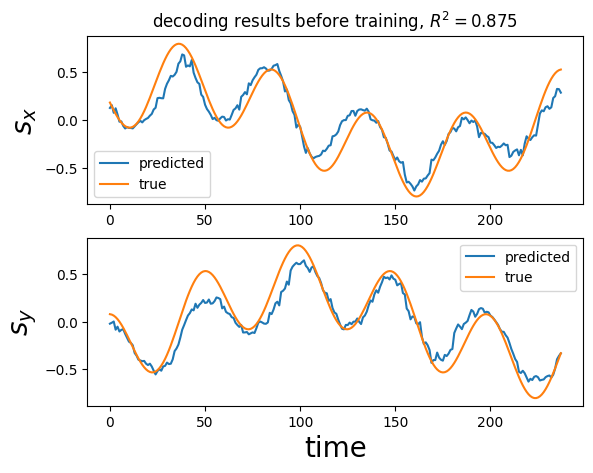

In [37]:
fig,ax = plt.subplots(2)
r2 = r2_score(y_test,y_pred)
ax[0].set_title(f'decoding results before training, $R^2={r2:.3}$')
ax[0].plot(y_pred[:,0],label='predicted')
ax[0].plot(y_test[:,0],label='true')
ax[0].set_ylabel('$s_x$',fontsize=20)
ax[0].legend()

ax[1].plot(y_pred[:,1],label='predicted')
ax[1].plot(y_test[:,1],label='true')
ax[1].set_ylabel('$s_y$',fontsize=20)
ax[1].set_xlabel('time',fontsize=20)
ax[1].legend()
plt.show()

In [25]:
fname = 'model.pth'

num_steps = 1000
num_samples = 1


dataset = RegressionDataset_wFreqs(timesteps=num_steps,num_samples=num_samples, mode=mode)
torch.manual_seed(seednum)
random.seed(seednum)
np.random.seed(seednum)
model = ConDivNet2dStimSparse_countTimeReadout(timesteps=num_steps, Nin=Nin, Nh=Nh, Nout=Nout, pcon=pcon, alpha=alpha).to(device)

try:
  model.load_state_dict(torch.load(fname, map_location = device))
  with torch.no_grad():
      feature = dataset.features
      label = dataset.labels
      label1 = dataset.labels1
      label2 = dataset.labels2
      feature = feature.to(device)
      s = label.to(device)
      readout, mem, spk1, spk2, spk3, spk4, spkh, spkout = model(s)

except FileNotFoundError:
  # train the network

  # locate zero-value weights before training loop
  EPS = 1e-6
  locked_masks = {n: torch.abs(w) < EPS for n, w in model.named_parameters() if n.endswith('weight')}
  loss_function = torch.nn.MSELoss()
  num_iter = 200 # train for this many iterations
  optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
  loss_hist = [] # record loss
  # training loop
  with tqdm.trange(num_iter) as pbar:
      for _ in pbar:
          minibatch_counter = 0
          loss_epoch = []
          feature = dataset.features
          label = dataset.labels
          label1 = dataset.labels1
          label2 = dataset.labels2
          feature = feature.to(device)
          s = label.to(device)
          readout, mem, spk1, spk2, spk3, spk4, spkh, spkout = model(s)
          tmax = readout.shape[0]
          # print(mem.shape)
          # print(readout.shape)
          loss_val = loss_function(readout, s[:tmax,:,:]) # calculate loss
          # loss_val = loss_function(mem, s) # calculate loss
          optimizer.zero_grad() # zero out gradients
          loss_val.backward() # calculate gradients
          for n, w in model.named_parameters():
              if w.grad is not None and n in locked_masks:
                  w.grad[locked_masks[n]] = 0
          optimizer.step() # update weights
      #         # store loss
          loss_hist.append(loss_val.item())
          minibatch_counter += 1
          pbar.set_postfix(loss="%.3e" % loss_val.item()) # print loss p/batch
  plt.plot(loss_hist)
  plt.ylabel('loss')
  plt.xlabel('iteration no.')
  plt.show()
  plt.close()

  # save trained model to external file for later loading
  torch.save(model.state_dict(), fname)

<ipython-input-25-7b4ad4248f85>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fname, map_location = device))


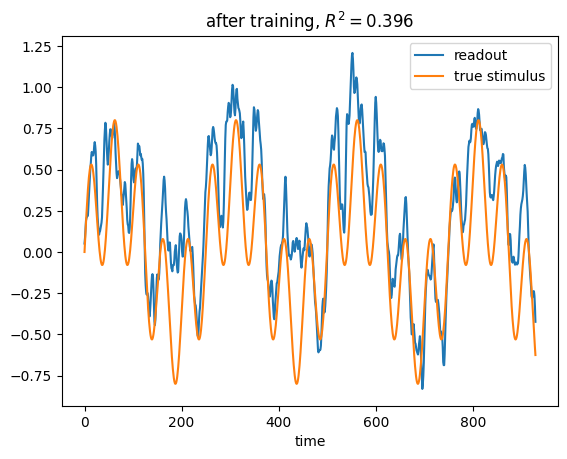

In [26]:
r2 = r2_score(s.detach().numpy()[:tmax,:,0], readout.detach().numpy()[:,:,0])
plt.title(f'after training, $R^2={r2:.3}$')
plt.plot(readout.detach().numpy()[:,1,0],label='readout')
plt.plot(s.detach().numpy()[:tmax,1,0],label='true stimulus')
plt.xlabel('time')
plt.legend()
plt.show()

In [30]:
# bin spikes
spk = spkout.cpu().detach().numpy() # decode the output spikes (change to 'spkh' to decode the hidden layer spikes)
deltat = 25 # larger deltat makes code run faster
tf=spk.shape[0]
n_neurons=spk.shape[1]
T=50
n_time_bins=int(T/deltat)
n_samples=tf-T+1
y=label[:n_samples,:,0].cpu()

# y4=y4full[:n_samples]
# y20=y20full[:n_samples]
X=np.zeros((n_samples,n_time_bins,n_neurons))
for n in range(n_samples):
    sub=spk[n:n+T,:]
    s=[np.sum(sub[x:x+deltat,:],axis=0) for x in range(0,T,deltat)]
    X[n,:,:]=s

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.5,shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_validate, y_validate, test_size=0.5,shuffle=False)
X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.5,shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_validate, y_validate, test_size=0.5,shuffle=False)

In [31]:
def rnn_evaluate(num_units,frac_dropout,n_epochs):
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    model_rnn=LSTMRegression(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_rnn.fit(X_train,y_train)
    y_valid_predicted_rnn=model_rnn.predict(X_valid)
    return r2_score(y_valid,y_valid_predicted_rnn)

#Do bayesian optimization
rnnBO = BayesianOptimization(f=rnn_evaluate,
                              pbounds={'num_units': (50, 600), 'frac_dropout': (0,.5), 'n_epochs': (2,21)},
                              verbose=0)
rnnBO.set_gp_params(alpha=1e-3)
rnnBO.maximize()
best_params=rnnBO.max['params']
frac_dropout=float(best_params['frac_dropout'])
n_epochs=int(best_params['n_epochs'])
num_units=int(best_params['num_units'])

# Run model w/ above hyperparameters
model_rnn=LSTMRegression(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
model_rnn.fit(X_train,y_train)
y_pred=model_rnn.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━

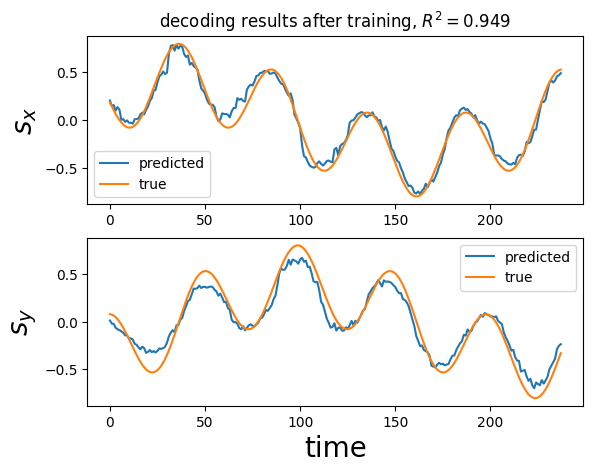

In [32]:
fig,ax = plt.subplots(2)
r2 = r2_score(y_test,y_pred)
ax[0].set_title(f'decoding results after training, $R^2={r2:.3}$')
ax[0].plot(y_pred[:,0],label='predicted')
ax[0].plot(y_test[:,0],label='true')
ax[0].set_ylabel('$s_x$',fontsize=20)
ax[0].legend()

ax[1].plot(y_pred[:,1],label='predicted')
ax[1].plot(y_test[:,1],label='true')
ax[1].set_ylabel('$s_y$',fontsize=20)
ax[1].set_xlabel('time',fontsize=20)
ax[1].legend()
plt.show()

mutual information, $R^2$, training the net, decode the output layer